In [ ]:
!pip install xgboost==0.90
!pip install catboost==0.18.1
!pip install shap

In [147]:
import os
import shap
import numpy as np
import pandas as pd
import xgboost as xgb
import catboost as cb
import matplotlib.pyplot as plt

from sklearn.metrics import roc_auc_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error

shap.initjs()

## Градиетный бустинг "на пальцах"

In [14]:
x = np.arange(0, 50)
x = pd.DataFrame({"x": x})

y1 = np.random.uniform(10,15,10)
y2 = np.random.uniform(20,25,10)
y3 = np.random.uniform(0,5,10)
y4 = np.random.uniform(30,32,10)
y5 = np.random.uniform(13,17,10)

y = np.concatenate((y1,y2,y3,y4,y5))
y = y[:,None]

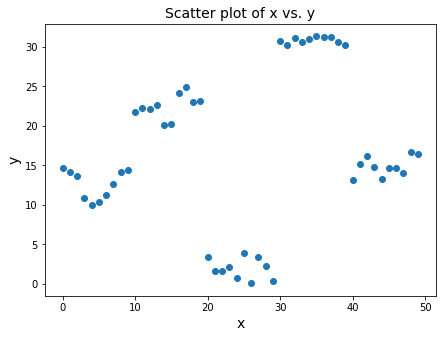

In [22]:
plt.figure(figsize=(7,5))
plt.plot(x, y, "o")
plt.title("Scatter plot of x vs. y", size=14)
plt.xlabel("x", size=14)
plt.ylabel("y", size=14)

plt.show()

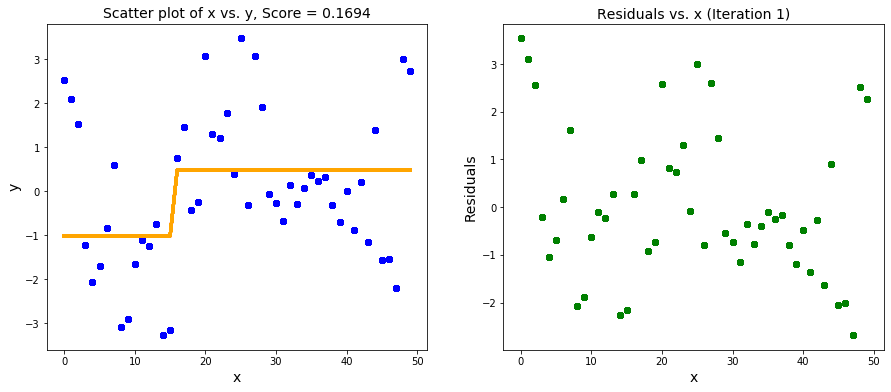

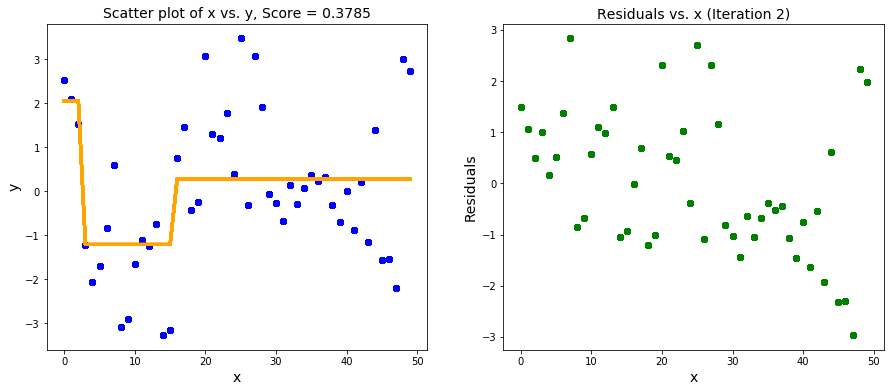

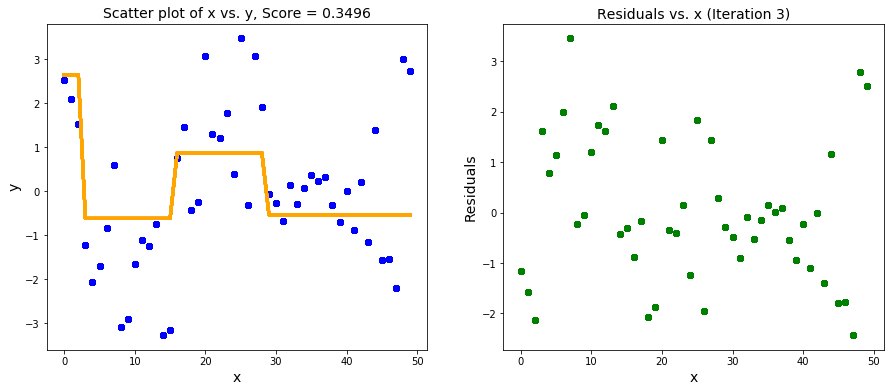

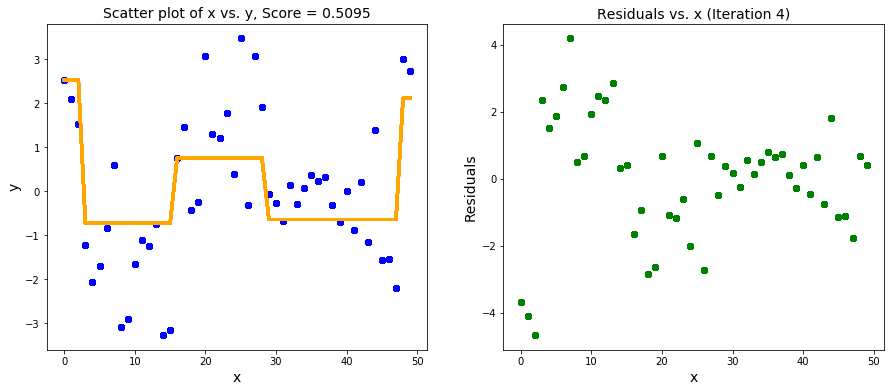

In [53]:
trees = []
y_ = y.copy()

for i in range(4):

    tree = DecisionTreeRegressor(max_depth=1, random_state=27)
    tree.fit(x, y_)

    trees.append(tree)
    y_pred = 0

    for tree in trees:
        y_pred += tree.predict(x)

    residuals = y_ - y_pred
    y_ = residuals
    score = r2_score(
        y, y_pred
    )

    plt.figure(figsize=(15, 6))
    plt.subplot(121)
    plt.plot(x, y, "o", color="blue")
    plt.plot(x, y_pred, color="orange", linewidth=3)
    plt.title(f"Scatter plot of x vs. y, Score = {round(score, 4)}", size=14)
    plt.xlabel("x", size=14)
    plt.ylabel("y", size=14)

    plt.subplot(122)
    plt.plot(x, residuals, "o", color="green")
    plt.title(f"Residuals vs. x (Iteration {i+1})", size=14)
    plt.ylabel("Residuals", size=14)
    plt.xlabel("x", size=14)
    plt.show()

## А как работает бэггинг?

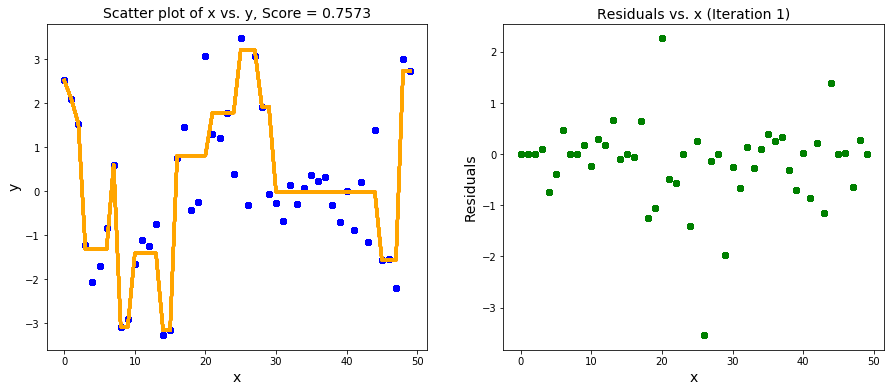

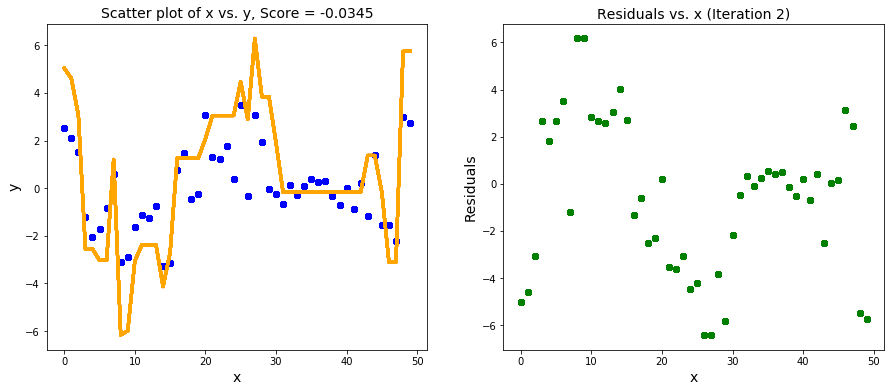

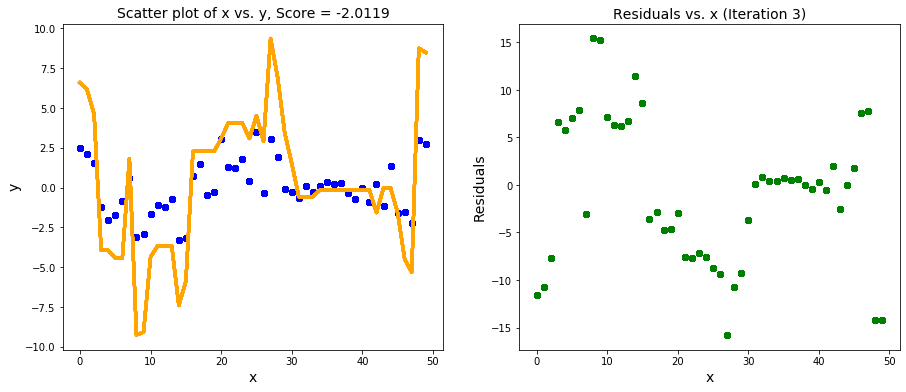

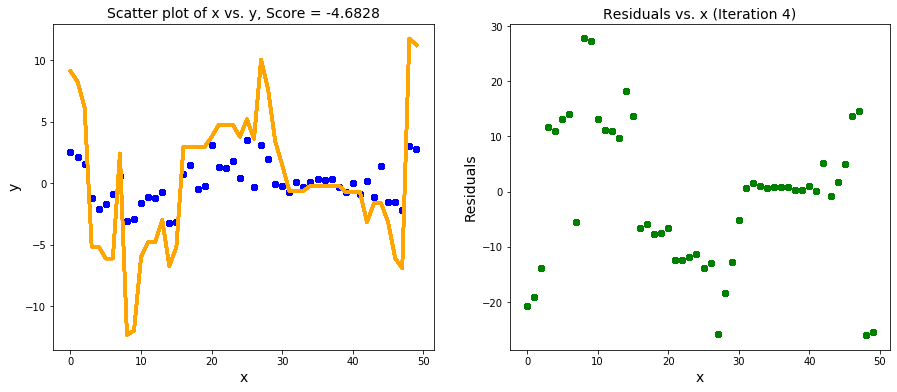

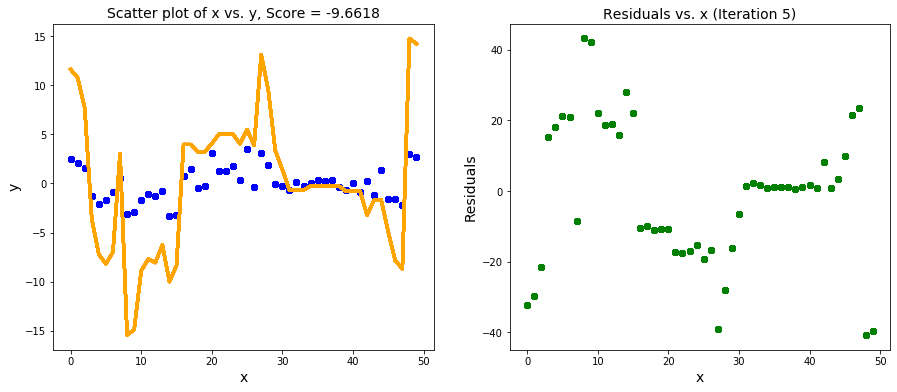

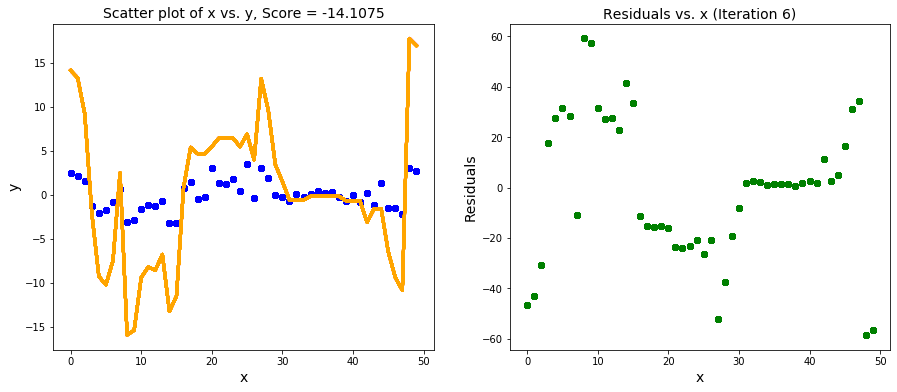

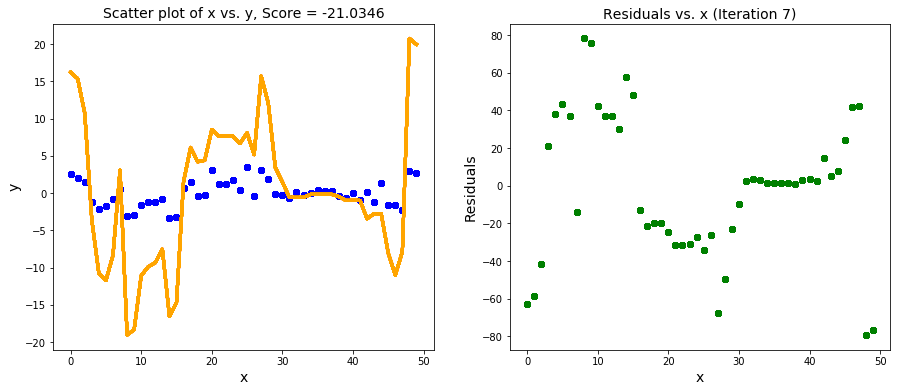

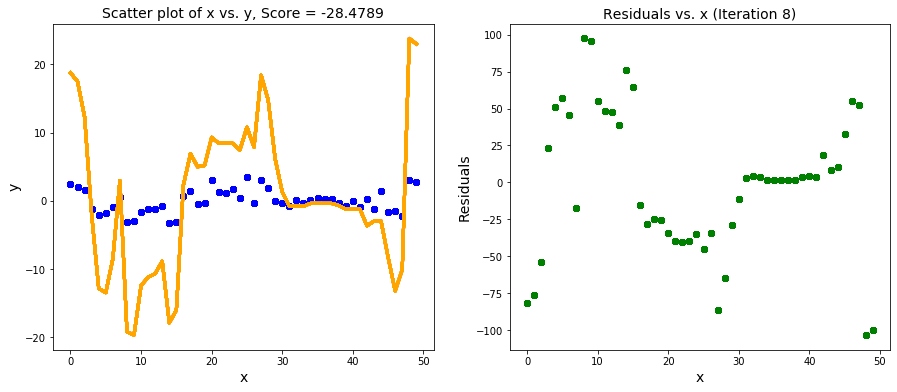

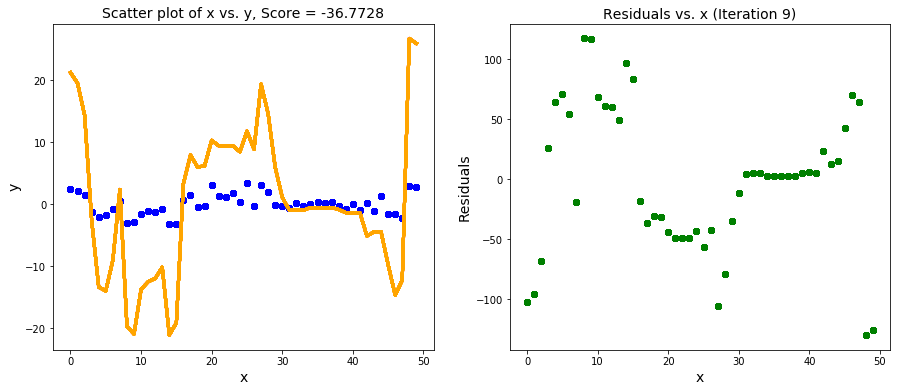

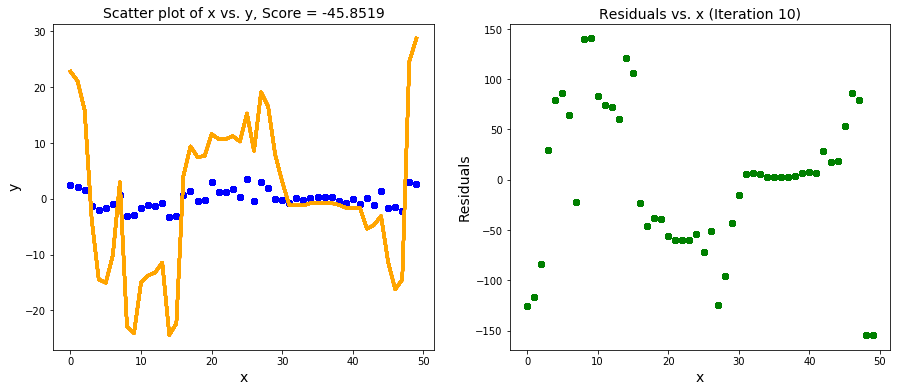

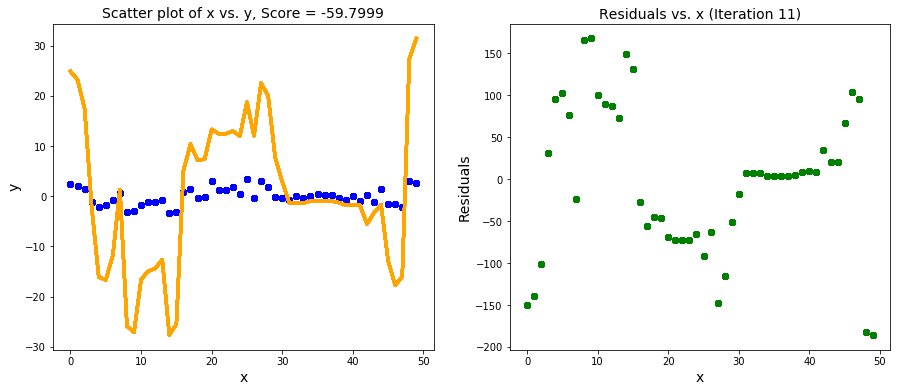

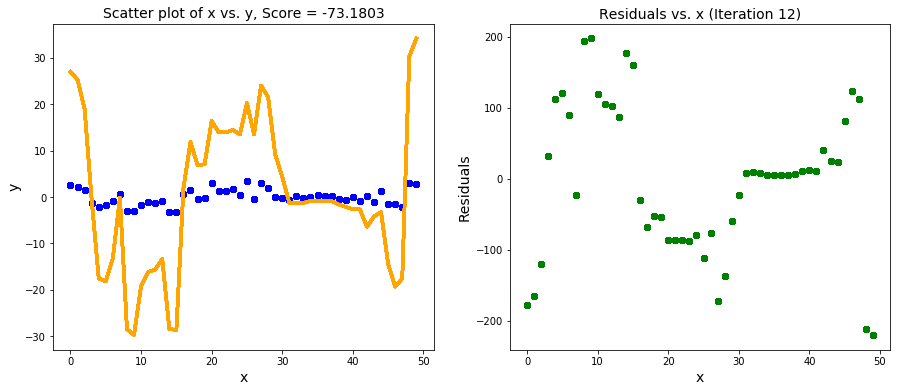

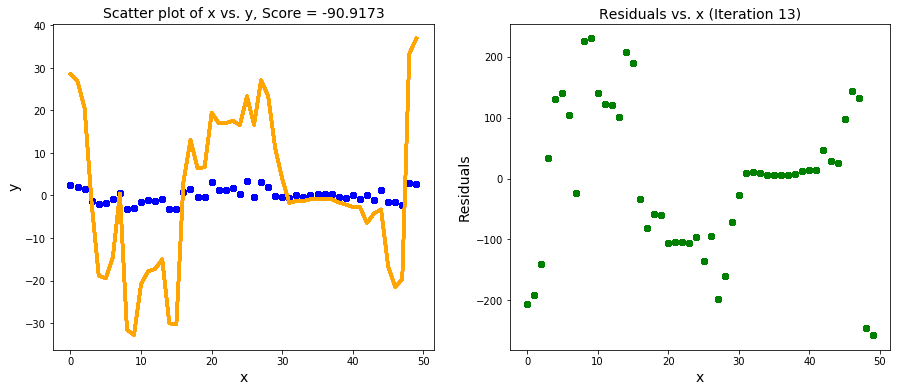

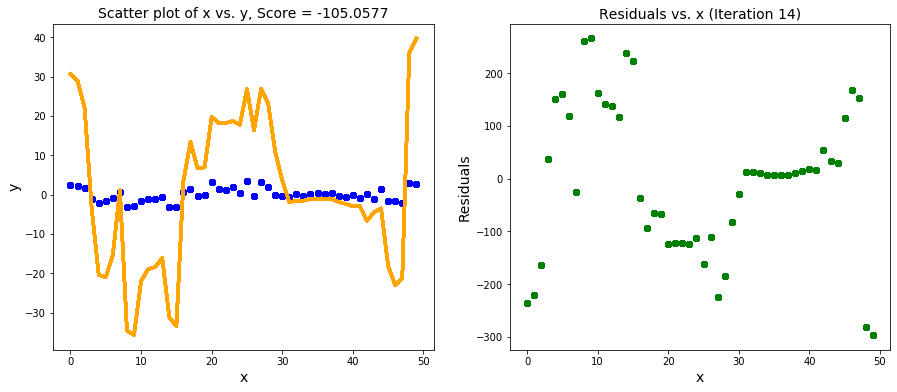

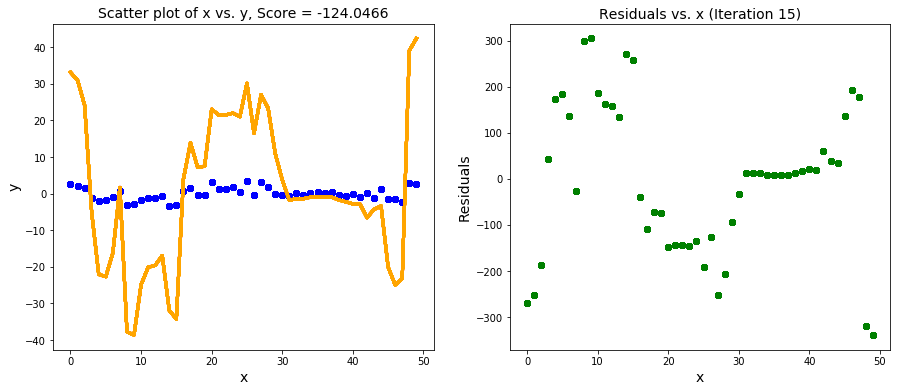

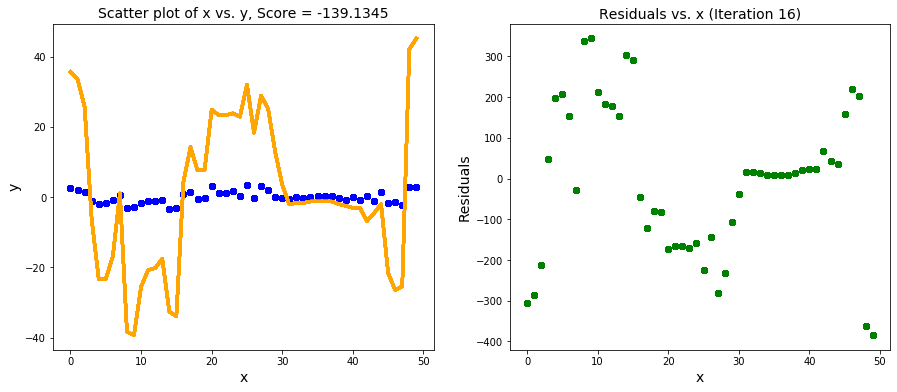

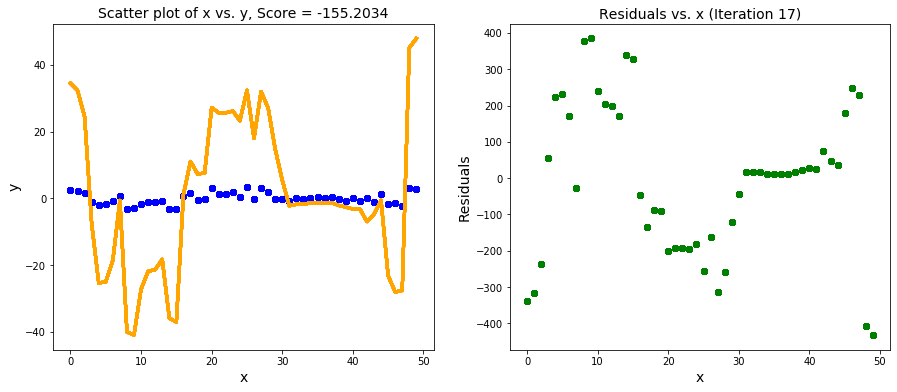

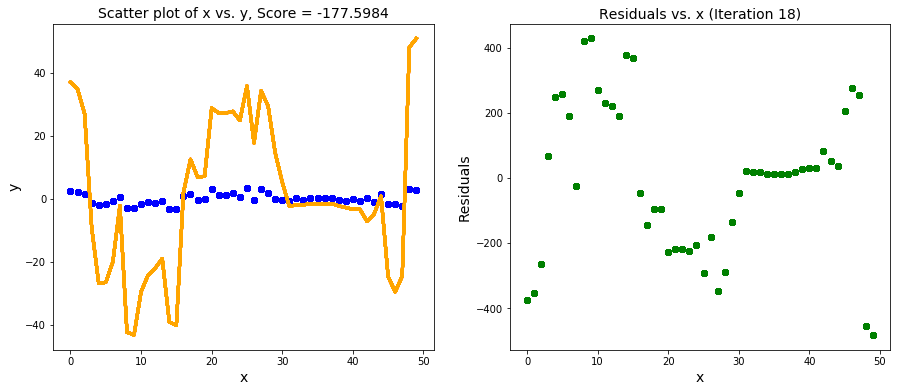

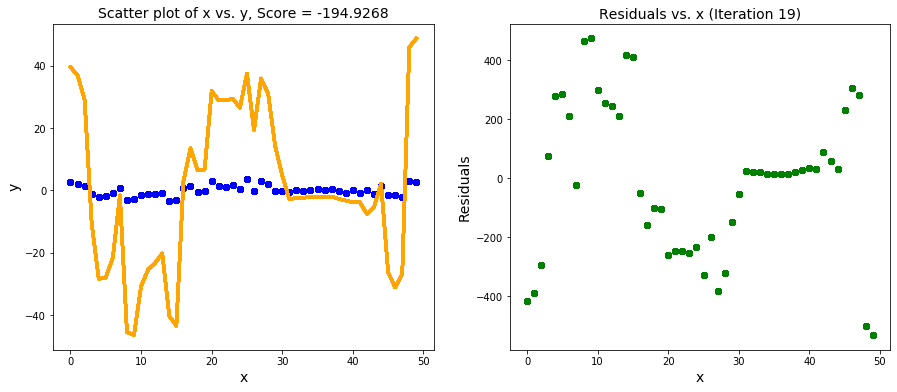

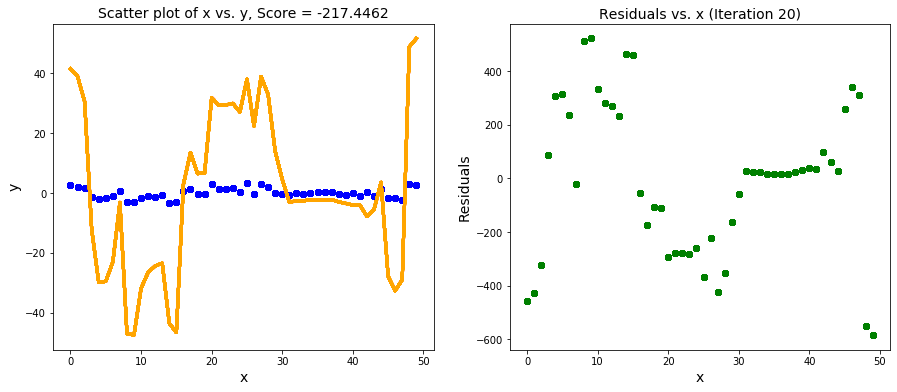

In [144]:
trees = []
y_ = y.copy()

for i in range(20):

    idx = np.random.randint(0, len(x), size=len(x))
    tree = DecisionTreeRegressor(max_depth=5, random_state=27)
    tree.fit(x.loc[idx], y[idx])

    trees.append(tree)
    y_pred = 0

    for tree in trees:
        y_pred += tree.predict(x)

    residuals = y_ - y_pred
    y_ = residuals
    score = r2_score(
        y, y_pred
    )

    plt.figure(figsize=(15, 6))
    plt.subplot(121)
    plt.plot(x, y, "o", color="blue")
    plt.plot(x, y_pred, color="orange", linewidth=3)
    plt.title(f"Scatter plot of x vs. y, Score = {round(score, 4)}", size=14)
    plt.xlabel("x", size=14)
    plt.ylabel("y", size=14)

    plt.subplot(122)
    plt.plot(x, residuals, "o", color="green")
    plt.title(f"Residuals vs. x (Iteration {i+1})", size=14)
    plt.ylabel("Residuals", size=14)
    plt.xlabel("x", size=14)
    plt.show()

## Загрузка данных

In [54]:
data = pd.read_csv("train.csv")
data.head(n=2)

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0,8.9255,-6.7863,11.9081,5.093,11.4607,-9.2834,5.1187,18.6266,...,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,train_1,0,11.5006,-4.1473,13.8588,5.389,12.3622,7.0433,5.6208,16.5338,...,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518


In [55]:
x_train, x_valid = train_test_split(
    data.drop(["ID_code", "target"], axis=1), train_size=0.7, random_state=1
)
y_train, y_valid = train_test_split(
    data["target"], train_size=0.7, random_state=1
)

## 1. Обучение базовой модели XGBoost (sklearn-API)

`XGBoost` поддерживает как свое собственное API, так и `sklearn-API`.

In [56]:
baseline = xgb.XGBClassifier(random_state=27)
baseline.fit(x_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=27,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [57]:
y_pred = baseline.predict_proba(x_valid)
score = roc_auc_score(y_valid, y_pred[:, 1])
print(f"score = {round(score, 4)}")

score = 0.8173


## 2. Обучение модели XGBoost с использование оригинального API

In [64]:
xgb_params = {
    "booster": "gbtree",
    "objective": "binary:logistic",
    "eval_metric": "auc",
    "learning_rate": 0.1,
    "reg_lambda": 100,
    "max_depth": 4,
    "nthread": 6,
    "gamma": 10,
    "seed": 27
}

dtrain = xgb.DMatrix(
    data=x_train, label=y_train
)
dvalid = xgb.DMatrix(
    data=x_valid, label=y_valid
)

In [65]:
evals_result = {}

model = xgb.train(
    params=xgb_params,
    dtrain=dtrain,
    num_boost_round=1000,
    maximize=True,
    early_stopping_rounds=50,
    evals_result=evals_result,
    evals=[(dtrain, "train"), (dvalid, "valid")],
    verbose_eval=25,
    
)

[0]	train-auc:0.535874	valid-auc:0.522539
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 50 rounds.
[25]	train-auc:0.79598	valid-auc:0.734062
[50]	train-auc:0.847714	valid-auc:0.776335
[75]	train-auc:0.876546	valid-auc:0.802633
[100]	train-auc:0.895706	valid-auc:0.817144
[125]	train-auc:0.908324	valid-auc:0.827664
[150]	train-auc:0.917521	valid-auc:0.836664
[175]	train-auc:0.923779	valid-auc:0.842864
[200]	train-auc:0.929381	valid-auc:0.848008
[225]	train-auc:0.933061	valid-auc:0.85123
[250]	train-auc:0.936981	valid-auc:0.85522
[275]	train-auc:0.94039	valid-auc:0.856979
[300]	train-auc:0.942774	valid-auc:0.85915
[325]	train-auc:0.945224	valid-auc:0.860701
[350]	train-auc:0.947117	valid-auc:0.862229
[375]	train-auc:0.948777	valid-auc:0.863689
[400]	train-auc:0.950363	valid-auc:0.864912
[425]	train-auc:0.95128	valid-auc:0.866331
[450]	train-auc:0.951616	valid-auc:0.866878
[475]	train-auc:0.951739	valid-a

Text(0, 0.5, 'ROC-AUC')

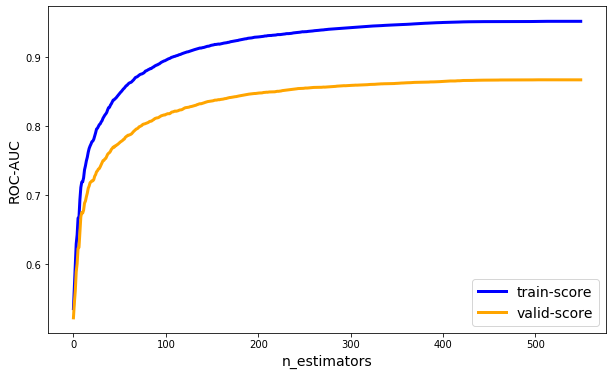

In [87]:
fig = plt.figure(figsize=(10, 6))
plt.plot(evals_result["train"]["auc"], linewidth=3, label="train-score", color="blue")
plt.plot(evals_result["valid"]["auc"], linewidth=3, label="valid-score", color="orange")
plt.legend(loc="best", fontsize=14)
plt.xlabel("n_estimators", size=14)
plt.ylabel("ROC-AUC", size=14)

In [74]:
cv_score = xgb.cv(
    dtrain=dtrain,
    params=xgb_params,
    num_boost_round=1000,
    early_stopping_rounds=50,
    verbose_eval=25,
    maximize=True,
    nfold=3,
)

[0]	train-auc:0.506997+0.00227279	test-auc:0.502616+0.0016775
[25]	train-auc:0.79962+0.00570583	test-auc:0.750186+0.00522845
[50]	train-auc:0.853181+0.00495827	test-auc:0.785345+0.00584787
[75]	train-auc:0.886262+0.00619125	test-auc:0.808374+0.00521186
[100]	train-auc:0.902804+0.00481189	test-auc:0.822285+0.00552684
[125]	train-auc:0.915166+0.00411315	test-auc:0.832244+0.00610349
[150]	train-auc:0.924162+0.00418319	test-auc:0.840553+0.00642424
[175]	train-auc:0.930429+0.00398267	test-auc:0.845827+0.00632343
[200]	train-auc:0.935598+0.00421615	test-auc:0.850197+0.00687476
[225]	train-auc:0.939888+0.00376806	test-auc:0.853634+0.00734655
[250]	train-auc:0.943402+0.00353726	test-auc:0.856298+0.00759503
[275]	train-auc:0.946075+0.00348201	test-auc:0.858379+0.00728405
[300]	train-auc:0.948385+0.00348639	test-auc:0.86058+0.00737802
[325]	train-auc:0.950242+0.00323236	test-auc:0.862499+0.00779128
[350]	train-auc:0.951117+0.00302754	test-auc:0.863132+0.00761819
[375]	train-auc:0.951695+0.002721

Text(0, 0.5, 'ROC-AUC')

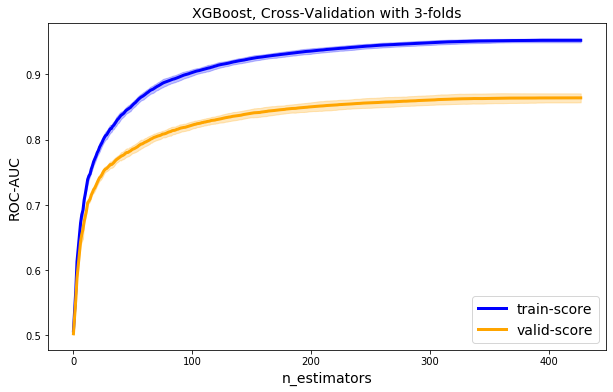

In [86]:
fig = plt.figure(figsize=(10, 6))
plt.title("XGBoost, Cross-Validation with 3-folds", size=14)
plt.plot(
    cv_score["train-auc-mean"],
    label="train-score",
    linewidth=3,
    color="blue"
)
plt.fill_between(
    x=range(cv_score.shape[0]),
    y1=cv_score["train-auc-mean"]-cv_score["train-auc-std"],
    y2=cv_score["train-auc-mean"]+cv_score["train-auc-std"],
    color="blue", alpha=0.25
)
plt.plot(
    cv_score["test-auc-mean"],
    label="valid-score",
    color="orange",
    linewidth=3
)
plt.fill_between(
    x=range(cv_score.shape[0]),
    y1=cv_score["test-auc-mean"]-cv_score["test-auc-std"],
    y2=cv_score["test-auc-mean"]+cv_score["test-auc-std"],
    color="orange", alpha=0.25
)
plt.legend(loc="best", fontsize=14)
plt.xlabel("n_estimators", size=14)
plt.ylabel("ROC-AUC", size=14)

## 3. Интерпретация работы модели XGBoost

In [145]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(x_valid)

## 3.1. Интерпретация поведения модели на одном объекте

In [148]:
shap.force_plot(
    explainer.expected_value,
    shap_values[0,:], x_valid.iloc[0,:],
    link="logit"
)

## 3.2. Пути принятия решений моделью на совокупности объектов

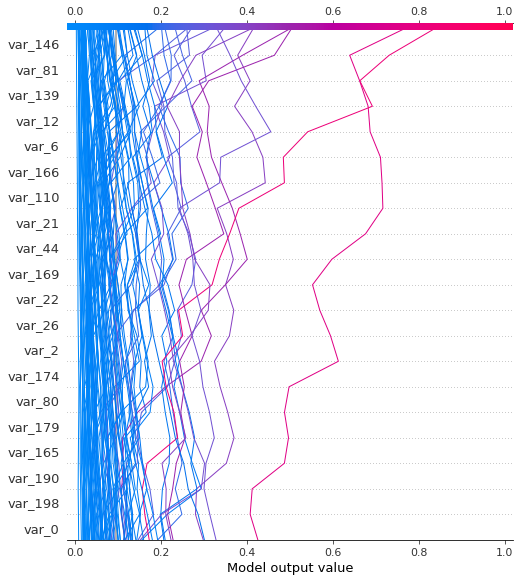

In [99]:
idx = np.random.randint(
    0, x_valid.shape[0], 100
)

shap.decision_plot(
    explainer.expected_value,
    shap_values[idx, :],
    x_valid.iloc[idx,:],
    link="logit")

## 3.3. Важность признаков для модели

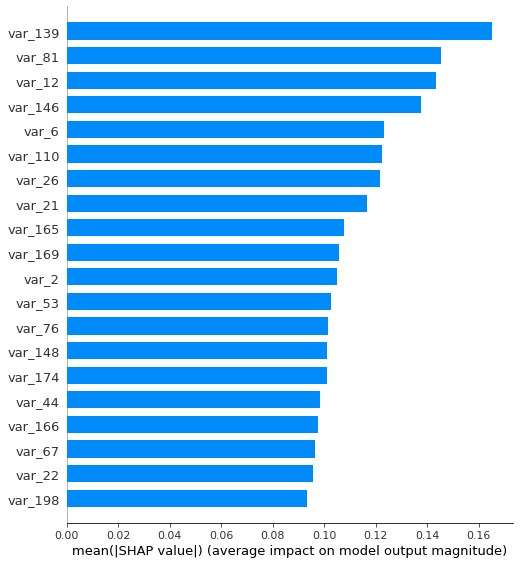

In [101]:
shap.summary_plot(
    shap_values, x_valid, plot_type="bar", max_display=20
)

## 3.4. Взаимодействие признаков между собой

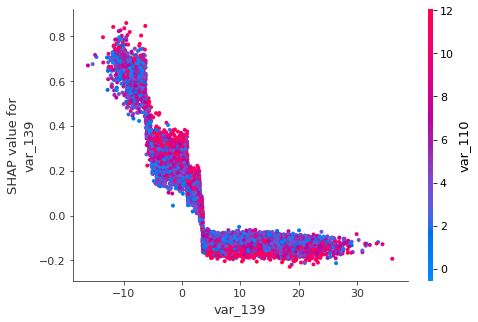

In [107]:
shap.dependence_plot("var_139", shap_values, x_valid)

## 3.5. Суммарный эффект для всех признаков

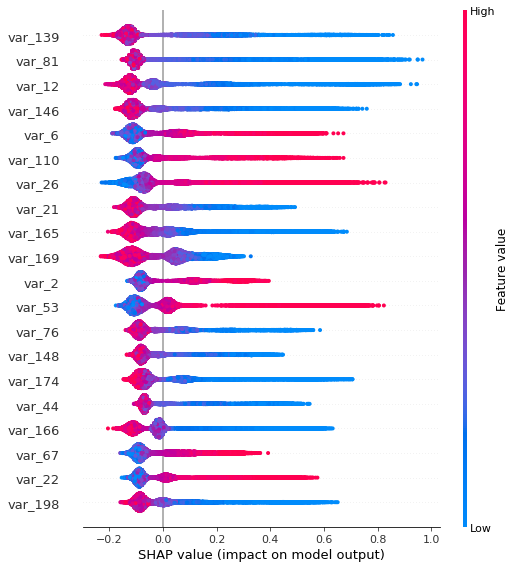

In [108]:
shap.summary_plot(shap_values, x_valid)

## 4. Обучение базовой модели CatBoost (sklearn-API)

`CatBoost` поддерживает как свое собственное `API`, так и `sklearn-API`.

In [116]:
model = cb.CatBoostClassifier(random_state=27)
model.fit(x_train, y_train)

Learning rate set to 0.048251
0:	learn: 0.6516779	total: 31.6ms	remaining: 31.6s
1:	learn: 0.6145449	total: 52.6ms	remaining: 26.2s
2:	learn: 0.5816579	total: 74ms	remaining: 24.6s
3:	learn: 0.5526536	total: 94.3ms	remaining: 23.5s
4:	learn: 0.5267749	total: 114ms	remaining: 22.7s
5:	learn: 0.5042161	total: 136ms	remaining: 22.5s
6:	learn: 0.4841894	total: 156ms	remaining: 22.2s
7:	learn: 0.4653544	total: 178ms	remaining: 22s
8:	learn: 0.4492514	total: 204ms	remaining: 22.5s
9:	learn: 0.4350686	total: 238ms	remaining: 23.6s
10:	learn: 0.4225826	total: 269ms	remaining: 24.1s
11:	learn: 0.4105939	total: 293ms	remaining: 24.1s
12:	learn: 0.4004183	total: 315ms	remaining: 24s
13:	learn: 0.3911709	total: 338ms	remaining: 23.8s
14:	learn: 0.3829585	total: 362ms	remaining: 23.7s
15:	learn: 0.3752520	total: 384ms	remaining: 23.6s
16:	learn: 0.3686091	total: 410ms	remaining: 23.7s
17:	learn: 0.3625052	total: 440ms	remaining: 24s
18:	learn: 0.3568153	total: 466ms	remaining: 24.1s
19:	learn: 0.35

167:	learn: 0.2475045	total: 5.1s	remaining: 25.3s
168:	learn: 0.2472508	total: 5.14s	remaining: 25.3s
169:	learn: 0.2470140	total: 5.18s	remaining: 25.3s
170:	learn: 0.2467470	total: 5.21s	remaining: 25.2s
171:	learn: 0.2465010	total: 5.23s	remaining: 25.2s
172:	learn: 0.2462025	total: 5.25s	remaining: 25.1s
173:	learn: 0.2459566	total: 5.28s	remaining: 25.1s
174:	learn: 0.2457352	total: 5.3s	remaining: 25s
175:	learn: 0.2454730	total: 5.33s	remaining: 25s
176:	learn: 0.2452244	total: 5.37s	remaining: 25s
177:	learn: 0.2449348	total: 5.41s	remaining: 25s
178:	learn: 0.2446734	total: 5.46s	remaining: 25s
179:	learn: 0.2443956	total: 5.49s	remaining: 25s
180:	learn: 0.2441382	total: 5.53s	remaining: 25s
181:	learn: 0.2438927	total: 5.57s	remaining: 25s
182:	learn: 0.2436602	total: 5.6s	remaining: 25s
183:	learn: 0.2434118	total: 5.64s	remaining: 25s
184:	learn: 0.2431856	total: 5.67s	remaining: 25s
185:	learn: 0.2429155	total: 5.69s	remaining: 24.9s
186:	learn: 0.2426941	total: 5.72s	re

328:	learn: 0.2116185	total: 9.45s	remaining: 19.3s
329:	learn: 0.2114346	total: 9.48s	remaining: 19.3s
330:	learn: 0.2112448	total: 9.52s	remaining: 19.2s
331:	learn: 0.2110442	total: 9.55s	remaining: 19.2s
332:	learn: 0.2108704	total: 9.59s	remaining: 19.2s
333:	learn: 0.2106464	total: 9.62s	remaining: 19.2s
334:	learn: 0.2104577	total: 9.65s	remaining: 19.1s
335:	learn: 0.2102893	total: 9.69s	remaining: 19.1s
336:	learn: 0.2101028	total: 9.73s	remaining: 19.1s
337:	learn: 0.2099058	total: 9.76s	remaining: 19.1s
338:	learn: 0.2097275	total: 9.8s	remaining: 19.1s
339:	learn: 0.2095421	total: 9.83s	remaining: 19.1s
340:	learn: 0.2093515	total: 9.87s	remaining: 19.1s
341:	learn: 0.2091517	total: 9.91s	remaining: 19.1s
342:	learn: 0.2089780	total: 9.95s	remaining: 19.1s
343:	learn: 0.2087656	total: 9.99s	remaining: 19s
344:	learn: 0.2085802	total: 10s	remaining: 19s
345:	learn: 0.2084030	total: 10s	remaining: 19s
346:	learn: 0.2082257	total: 10.1s	remaining: 19s
347:	learn: 0.2080290	tot

490:	learn: 0.1849891	total: 14.5s	remaining: 15.1s
491:	learn: 0.1848446	total: 14.6s	remaining: 15s
492:	learn: 0.1847086	total: 14.6s	remaining: 15s
493:	learn: 0.1845652	total: 14.6s	remaining: 15s
494:	learn: 0.1844433	total: 14.6s	remaining: 14.9s
495:	learn: 0.1842824	total: 14.7s	remaining: 14.9s
496:	learn: 0.1841630	total: 14.7s	remaining: 14.9s
497:	learn: 0.1840087	total: 14.7s	remaining: 14.9s
498:	learn: 0.1838723	total: 14.8s	remaining: 14.8s
499:	learn: 0.1837432	total: 14.8s	remaining: 14.8s
500:	learn: 0.1836078	total: 14.8s	remaining: 14.8s
501:	learn: 0.1834690	total: 14.8s	remaining: 14.7s
502:	learn: 0.1833293	total: 14.9s	remaining: 14.7s
503:	learn: 0.1832310	total: 14.9s	remaining: 14.6s
504:	learn: 0.1831033	total: 14.9s	remaining: 14.6s
505:	learn: 0.1829461	total: 14.9s	remaining: 14.6s
506:	learn: 0.1827852	total: 14.9s	remaining: 14.5s
507:	learn: 0.1826589	total: 15s	remaining: 14.5s
508:	learn: 0.1825202	total: 15s	remaining: 14.5s
509:	learn: 0.1823990	

657:	learn: 0.1639203	total: 18.6s	remaining: 9.65s
658:	learn: 0.1638002	total: 18.6s	remaining: 9.62s
659:	learn: 0.1636741	total: 18.6s	remaining: 9.59s
660:	learn: 0.1635661	total: 18.6s	remaining: 9.56s
661:	learn: 0.1634491	total: 18.7s	remaining: 9.53s
662:	learn: 0.1633327	total: 18.7s	remaining: 9.5s
663:	learn: 0.1632322	total: 18.7s	remaining: 9.47s
664:	learn: 0.1631115	total: 18.7s	remaining: 9.44s
665:	learn: 0.1630087	total: 18.8s	remaining: 9.4s
666:	learn: 0.1629120	total: 18.8s	remaining: 9.38s
667:	learn: 0.1627991	total: 18.8s	remaining: 9.35s
668:	learn: 0.1626694	total: 18.8s	remaining: 9.32s
669:	learn: 0.1625591	total: 18.9s	remaining: 9.29s
670:	learn: 0.1624453	total: 18.9s	remaining: 9.26s
671:	learn: 0.1623184	total: 18.9s	remaining: 9.22s
672:	learn: 0.1622080	total: 18.9s	remaining: 9.19s
673:	learn: 0.1620850	total: 19s	remaining: 9.17s
674:	learn: 0.1619718	total: 19s	remaining: 9.14s
675:	learn: 0.1618436	total: 19s	remaining: 9.11s
676:	learn: 0.161728

818:	learn: 0.1473906	total: 23.2s	remaining: 5.13s
819:	learn: 0.1473143	total: 23.2s	remaining: 5.1s
820:	learn: 0.1472187	total: 23.2s	remaining: 5.07s
821:	learn: 0.1471362	total: 23.3s	remaining: 5.04s
822:	learn: 0.1470123	total: 23.3s	remaining: 5.01s
823:	learn: 0.1469178	total: 23.3s	remaining: 4.98s
824:	learn: 0.1468418	total: 23.3s	remaining: 4.95s
825:	learn: 0.1467501	total: 23.4s	remaining: 4.92s
826:	learn: 0.1466488	total: 23.4s	remaining: 4.89s
827:	learn: 0.1465505	total: 23.4s	remaining: 4.86s
828:	learn: 0.1464514	total: 23.4s	remaining: 4.83s
829:	learn: 0.1463278	total: 23.5s	remaining: 4.8s
830:	learn: 0.1462228	total: 23.5s	remaining: 4.78s
831:	learn: 0.1461219	total: 23.5s	remaining: 4.75s
832:	learn: 0.1460433	total: 23.5s	remaining: 4.72s
833:	learn: 0.1459507	total: 23.6s	remaining: 4.69s
834:	learn: 0.1458943	total: 23.6s	remaining: 4.66s
835:	learn: 0.1457939	total: 23.6s	remaining: 4.63s
836:	learn: 0.1456902	total: 23.6s	remaining: 4.6s
837:	learn: 0.1

977:	learn: 0.1334001	total: 27.1s	remaining: 609ms
978:	learn: 0.1333270	total: 27.1s	remaining: 581ms
979:	learn: 0.1332285	total: 27.1s	remaining: 553ms
980:	learn: 0.1331430	total: 27.1s	remaining: 526ms
981:	learn: 0.1330305	total: 27.2s	remaining: 498ms
982:	learn: 0.1329514	total: 27.2s	remaining: 470ms
983:	learn: 0.1328837	total: 27.2s	remaining: 443ms
984:	learn: 0.1327992	total: 27.2s	remaining: 415ms
985:	learn: 0.1327237	total: 27.3s	remaining: 387ms
986:	learn: 0.1326509	total: 27.3s	remaining: 359ms
987:	learn: 0.1325524	total: 27.3s	remaining: 332ms
988:	learn: 0.1324593	total: 27.3s	remaining: 304ms
989:	learn: 0.1324038	total: 27.4s	remaining: 276ms
990:	learn: 0.1323206	total: 27.4s	remaining: 249ms
991:	learn: 0.1322274	total: 27.4s	remaining: 221ms
992:	learn: 0.1321271	total: 27.4s	remaining: 193ms
993:	learn: 0.1320390	total: 27.5s	remaining: 166ms
994:	learn: 0.1319365	total: 27.5s	remaining: 138ms
995:	learn: 0.1318700	total: 27.5s	remaining: 110ms
996:	learn: 

In [117]:
y_pred = model.predict_proba(x_valid)
score = roc_auc_score(y_valid, y_pred[:, 1])
print(f"score = {round(score, 4)}")

score = 0.8757


## 5. Обучение модели CatBoost с использование оригинального API

In [149]:
cb_params = {
    "n_estimators": 5000,
    "learning_rate": 0.01,
    "loss_function": "Logloss",
    "eval_metric": "AUC",
    "task_type": "CPU",
    "verbose": 50,
    "max_depth": 6,
    "l2_leaf_reg": 10,
    "early_stopping_rounds": 50,
    "thread_count": 6,
    "random_seed": 42
}

cb_train = cb.Pool(
    data=x_train, label=y_train, cat_features=None
)
cb_valid = cb.Pool(
    data=x_valid, label=y_valid, cat_features=None
)

In [150]:
model = cb.train(
    params=cb_params,
    dtrain=cb_train,
    eval_set=[cb_train, cb_valid],
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.5714514	test1: 0.5578283	best: 0.5578283 (0)	total: 98.4ms	remaining: 8m 11s
50:	test: 0.8184036	test1: 0.7509907	best: 0.7525828 (46)	total: 2.75s	remaining: 4m 26s
100:	test: 0.8246483	test1: 0.7699136	best: 0.7773525 (87)	total: 5.02s	remaining: 4m 3s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.777352503
bestIteration = 87

Shrink model to first 88 iterations.


In [151]:
catboost_cv = cb.cv(
    pool=cb_train,
    params=cb_params,
    plot=True,
    nfold=3,
    seed=27
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.5651674	best: 0.5651674 (0)	total: 215ms	remaining: 17m 55s
50:	test: 0.7658977	best: 0.7658977 (50)	total: 8.1s	remaining: 13m 6s
100:	test: 0.7865305	best: 0.7891006 (84)	total: 16.1s	remaining: 13m 1s
Stopped by overfitting detector  (50 iterations wait)
